In [5]:
import pandas as pd
import numpy as pd 
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim

import numpy as np 
from torch.autograd import Variable
from scipy.spatial import distance_matrix
import torch.nn as nn


### Toy dataset:

Text(0.5, 1.0, 'Make moons dataset')

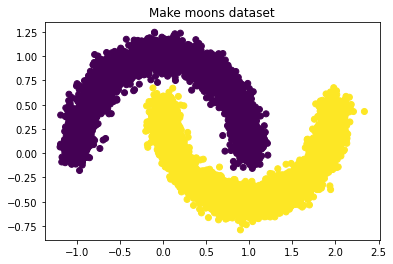

In [23]:
np.random.seed(3)
X,y = make_moons(n_samples=10_000,noise=0.08)
plt.scatter(X[:,0],X[:,1],c=y)
plt.title("Make moons dataset")

In [24]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25, random_state=1)


# Scale 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


# Convert to torch tensors
X_train=torch.from_numpy(X_train.astype(np.float32))
X_test=torch.from_numpy(X_test.astype(np.float32))
y_train=torch.from_numpy(y_train.astype(np.float32))
y_test=torch.from_numpy(y_test.astype(np.float32))
X_val=torch.from_numpy(X_val.astype(np.float32))
y_val=torch.from_numpy(y_val.astype(np.float32))

# Reshape to fit a model
y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)
y_val=y_val.view(y_val.shape[0],1)

### MLP model :

In [25]:
# MLP in pytorch 
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input = torch.nn.Linear(2, 5)
        self.output = torch.nn.Linear(5, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.ReLU = torch.nn.ReLU()
    def forward(self, x):
        x_input = self.input(x)
        x_output = self.output(self.ReLU(x_input))
        out = self.sigmoid(x_output)
        return out   


model = MLP()

'''
# Define the loss
criterion=torch.nn.BCELoss(reduction="mean")
# Define the Optimizer 
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

train_loss = [] 
valid_loss = []

model.train()
number_of_epochs=10_000
for epoch in range(number_of_epochs):

    # Train 

    y_prediction=model(X_train)
    loss=criterion(y_prediction,y_train)
    train_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%10 == 0:
        print('epoch:', epoch+1,',loss=',loss.item())

    # Valid
    with torch.no_grad():
        y_prediction_val=model(X_val)    
        loss_valid=criterion(y_prediction_val,y_val)    
        valid_loss.append(loss_valid.item())   

model.eval()
with torch.no_grad():
    y_pred=model(X_test)
    y_pred_class=y_pred.round()
    accuracy=(y_pred_class.eq(y_test).sum())/float(y_test.shape[0])
    print("Accuracy on test is {}:".format(accuracy.item()))
    
plt.plot(range(number_of_epochs),train_loss,label="train_loss")
plt.plot(range(number_of_epochs),valid_loss,label="valid_loss")
plt.legend()
plt.title("Loss")

torch.save(model.state_dict(),"mlp_toy_model")

'''
model.load_state_dict(torch.load("mlp_toy_model"))

<All keys matched successfully>

In [26]:
with torch.no_grad():
    # Predictions on train 
    y_pred_train_proba = model(X_train)
    y_pred_train_class = y_pred_train_proba.round().numpy().flatten()
    # Predictions on test 
    y_pred_test_proba = model(X_test)
    y_pred_test_class = y_pred_test_proba.round().numpy().flatten()

Decision frontier : 

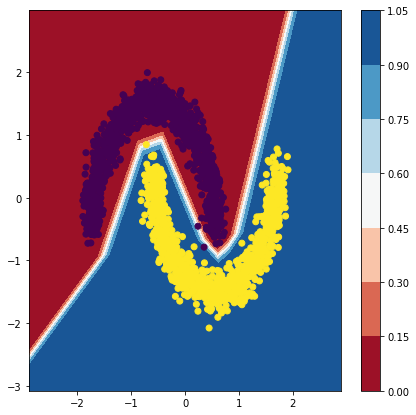

In [28]:
X_plot = X_test.numpy()

plot_step = 0.02
x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()) 
#Z = (Z > 0.5).int()

Z = Z.reshape(xx.shape).detach().numpy()


plt.figure(figsize=(7,7))
c = plt.contourf(xx, yy, Z, cmap="RdBu")
plt.colorbar(c)
plt.scatter(X_plot[:,0],X_plot[:,1],c=y_test.numpy())

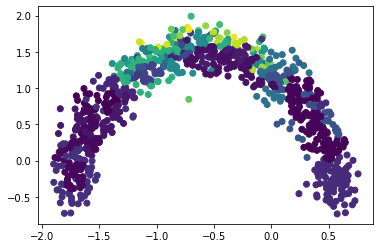

In [39]:
pred_class=0
cluster_label = np.loadtxt("cluster_label_class={}.txt".format(pred_class))
perturbs =  np.loadtxt("perturbs_class={}.txt".format(pred_class))
X_cluster = X_test[y_pred_test_class==pred_class]
plt.figure()
plt.scatter(X_cluster[:,0],X_cluster[:,1],c=cluster_label)

In [59]:
X_cluster

tensor([[-1.6501, -0.0909],
        [ 0.5661,  0.3973],
        [-0.0053,  1.1134],
        ...,
        [-1.7351, -0.5853],
        [ 0.5056,  0.1342],
        [ 0.4081, -0.0711]])

In [69]:
all_perturbs = np.vstack([perturbs[e] for e in cluster_label.astype(int)])
X_new = X_cluster + all_perturbs

In [58]:

cluster_label 

array([ 2., 26., 26., ..., 14.,  1., 12.])

In [54]:
np.where(cluster_label == 1)[0]

array([  13,   26,   30,   33,   39,   44,   46,   48,   54,   59,   60,
         65,   67,   74,   78,   81,   84,  147,  149,  160,  172,  178,
        180,  181,  182,  185,  187,  192,  195,  200,  203,  205,  210,
        216,  223,  230,  233,  237,  243,  244,  245,  251,  264,  278,
        284,  297,  309,  327,  330,  333,  334,  336,  342,  345,  370,
        372,  378,  384,  389,  390,  394,  407,  415,  418,  422,  445,
        447,  448,  452,  453,  468,  469,  474,  477,  480,  484,  488,
        489,  509,  525,  535,  548,  550,  553,  554,  557,  563,  564,
        579,  591,  593,  615,  616,  619,  626,  629,  637,  639,  640,
        646,  652,  657,  661,  676,  682,  696,  702,  706,  712,  720,
        729,  732,  736,  740,  742,  750,  754,  758,  762,  784,  787,
        788,  797,  800,  805,  808,  810,  823,  833,  838,  840,  842,
        848,  853,  856,  857,  860,  867,  879,  887,  891,  906,  907,
        913,  918,  925,  931,  934,  951,  956,  9

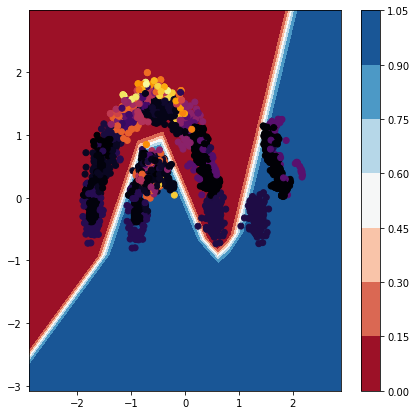

In [73]:
import matplotlib.cm as cm
X_plot = X_test.numpy()

plot_step = 0.02
x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()) 
#Z = (Z > 0.5).int()

Z = Z.reshape(xx.shape).detach().numpy()


plt.figure(figsize=(7,7))
c = plt.contourf(xx, yy, Z, cmap="RdBu")
plt.colorbar(c)


pred_class=0
cluster_label = np.loadtxt("cluster_label_class={}.txt".format(pred_class))
perturbs =  np.loadtxt("perturbs_class={}.txt".format(pred_class))
X_cluster = X_test[y_pred_test_class==pred_class]

all_perturbs = np.vstack([perturbs[e] for e in cluster_label.astype(int)])
X_new = X_cluster + all_perturbs


plt.scatter(X_cluster[:,0],X_cluster[:,1],c=cluster_label,cmap="inferno")
plt.scatter(X_new[:,0],X_new[:,1],c=cluster_label,cmap="inferno")